In [1]:
# If you run on google colab uncomment bellow comment
# !pip install torchmetrics pytorch-lightning torchvision -qq
# !pip install imutils

import copy
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from math import *

import torch
import torchvision
from torchvision.datasets import GTSRB
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torchmetrics import Accuracy

import lightning as pl # Pytorch lightning is a wrapper for pytorch that makes it easier to train models
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from lightning.pytorch.callbacks.progress import RichProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme


from torch.optim.lr_scheduler import StepLR

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

BATCH_SIZE = 256 if torch.cuda.is_available() else 64
# Define GPU number
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
num_workers = 0 # Set to your device
torch.set_float32_matmul_precision('medium')
import json

In [2]:
dfs = pd.read_pickle("2019_hh_trials_all.pickle")

In [3]:
def next_inrt(player_idx,current_i,L,dfs,step=1):
    for i in range(current_i,L,step):
        row = dfs.iloc[i]

        ja = row['joint_action']
        ja = ja.replace("\'","\"")
        y_act = json.loads(ja)

        #Output/GT
        y = None

        # for y_row in y_act: # action pair for each player
        y_row = y_act[player_idx]
        if y_row == 'INTERACT':
            y=0
        elif y_row[0]==1:
            y=1
        elif y_row[0]==-1:
            y=2
        elif y_row[1]==1:
            y=3
        elif y_row[1]==-1:
            y=4
        else: #No action
            y=5

        if row['time_left']==-1:
            return None, -1
        if y==0:
            state = json.loads(row['state'])
            player = state['players'][player_idx]
            player_pos = (player['position'][0],player['position'][1])
            player_or = (player['orientation'][0],player['orientation'][1])

            player_look_pos = np.array([player_pos[0]+player_or[0],player_pos[1]+player_or[1]])
            
            return player_look_pos, i
    
    raise Exception("oh no")
    return None, -1

In [4]:
#Fixed sized inputs for NN v2
L = len(dfs)
step = 1
print(L)
input_list = [] 
output_list = [] 
index_list = []
map_list = []
save_img_idx = -1
target_list = ['X','P','O','D','S']
# Processing into array for NN
nxt_inrt_idx = [-1,-1]
nxt_inrt_pos = [[0,0],[0,0]]

for i in range(0,L,step):
    row = dfs.iloc[i]

    ja = row['joint_action']
    ja = ja.replace("\'","\"")
    y_act = json.loads(ja)

    #Add entry for both players
    for player_idx in [0,1]:
        #Output/GT
        y = 0

        # for y_row in y_act: # action pair for each player
        y_row = y_act[player_idx]
        if y_row == 'INTERACT':
            y=0
        elif y_row[0]==1:
            y=1
        elif y_row[0]==-1:
            y=2
        elif y_row[1]==1:
            y=3
        elif y_row[1]==-1:
            y=4
        else: #No action
            y=5

        if y!=5:
            save_img_idx+=1
        if y!=5 and row['time_left']!=-1: #Filters out wait actions
            
            # if i>nxt_inrt_idx[player_idx]:
            nxt_inrt_pos[player_idx], nxt_inrt_idx[player_idx] = next_inrt(player_idx,i,L, dfs, step)
            # print(nxt_inrt_pos[player_idx], nxt_inrt_idx[player_idx], player_idx)
            if nxt_inrt_pos[player_idx] is None:
                break


            future_row = dfs.iloc[i+1]
            future_state = json.loads(future_row['state'])
            state = json.loads(row['state'])
            player = state['players'][player_idx]
            player_pos = (player['position'][0],player['position'][1])
            player_or = (player['orientation'][0],player['orientation'][1])
            future_player = future_state['players'][player_idx]
            future_player_pos = (future_player['position'][0],future_player['position'][1])
            future_player_or = (future_player['orientation'][0],player['orientation'][1])
            if future_player_pos==player_pos and future_player_or==player_or and y!=0:#if action made no change and is not interact
                pass
            else:
                # Map layout data
                # 0 - Map exists 0/1
                # 1 - Bench (X) 0/1
                # 2 - Pot 0/1
                # 3 - Onion Source 0/1
                # 4 - Dish Source 0/1
                # 5 - Serving 0/1
                # 6 - Pot onions 0-3
                # 7 - Pot tick 0-20
                # 8 - Placed onions 0/1 incl. player held
                # 9 - Placed dishes 0/1 incl. player held
                # 10 - placed soups 0/1 incl. player held
                # 11 - P1 O1 -1/0/1 @ Player location
                # 12 - P1 O2 -1/0/1 @ Player location
                # 13 - P2 O1 -1/0/1 @ player location
                # 14 - P2 O2 -1/0/1 @ player location
                
                map_layout = row['layout']
                map_layout = map_layout.replace("\'","\"")
                map_layout = json.loads(map_layout)

                x = np.zeros([15,5,9]) #biggest map size
                pot_locations = []

                ## partial 8-10, 11-14
                state = json.loads(row['state'])

                for player in [state['players'][player_idx], state['players'][(player_idx+1)%2]]:
                    #Position
                    player_pos = (player['position'][0],player['position'][1])
                    #Orientation
                    player_or = (player['orientation'][0],player['orientation'][1])

                    or_idx = 11
                    if player_idx==1:
                        or_idx = 13
                    
                    x[or_idx, player_pos[1],player_pos[0]] = player_or[0]
                    x[or_idx+1, player_pos[1],player_pos[0]] = player_or[1]

                    #Held object converter
                    if player["held_object"] is None:
                        pass
                    else:
                        if player["held_object"]['name'] == "onion":
                            x[8, player_pos[1],player_pos[0]] = 1
                        elif player["held_object"]['name'] == "dish":
                            x[9, player_pos[1],player_pos[0]] = 1
                        elif player["held_object"]['name'] == "soup":
                            x[10, player_pos[1],player_pos[0]] = 1
                        else:
                            print("unknown held item", player["held_object"]['name'])

                ## 0-5
                for map_row_idx in range(len(map_layout)):
                    for map_col_idx in range(len(map_layout[0])):

                        # 0
                        x[0,map_row_idx,map_col_idx]=1

                        # 1-5
                        tile = map_layout[map_row_idx][map_col_idx]
                        for target_idx in range(len(target_list)):
                            if target_list[target_idx] == tile:
                                x[target_idx+1, map_row_idx,map_col_idx] = 1

                ## partial 8-10, 6-7
                object_list = state['objects']
                for obj in object_list:
                    obj_name = obj['name']
                    obj_pos = obj['position']

                    if obj_name == "onion":
                        x[8, obj_pos[1],obj_pos[0]] = 1
                    elif obj_name == "dish":
                        x[9, obj_pos[1],obj_pos[0]] = 1
                    elif obj_name == "soup":
                        x[6, obj_pos[1],obj_pos[0]] = len(obj['_ingredients'])
                        x[10, obj_pos[1],obj_pos[0]] = 1
                        if obj['is_ready']:
                            x[7, obj_pos[1],obj_pos[0]] = obj['cooking_tick']
                
                #{'name': 'soup', 'position': [4, 2], '_ingredients': [{'name': 'onion', 'position': [4, 2]}, {'name': 'onion', 'position': [4, 2]}, {'name': 'onion', 'position': [4, 2]}], 'cooking_tick': 20, 'is_cooking': False, 'is_ready': True, 'is_idle': False, 'cook_time': 20, '_cooking_tick': 20}
                #{'name': 'soup', 'position': [8, 3], '_ingredients': [{'name': 'onion', 'position': [8, 3]}, {'name': 'onion', 'position': [8, 3]}, {'name': 'onion', 'position': [8, 3]}], 'cooking_tick': 20, 'is_cooking': False, 'is_ready': True, 'is_idle': False, 'cook_time': 20, '_cooking_tick': 20}
                index_list.append((save_img_idx,player_idx))
                input_list.append(x)
                output_list.append(nxt_inrt_pos[player_idx])


103141


In [5]:
# print(input_list[0].shape)
print(len(input_list))

66349


In [6]:
# RANDOM
np.random.seed(1234)
list_train_input = []
list_train_output = []
list_train_index = []

list_valtest_input = []
list_valtest_output = []
list_valtest_index = []

train_prob = 0.7
no_samples = len(input_list)

means = np.zeros([15])
stds = np.zeros([15])
count = 0
for split_idx in range(no_samples):
    rand_float = np.random.rand()
    if rand_float<train_prob:
        list_train_input.append(input_list[split_idx])
        list_train_output.append(output_list[split_idx])
        list_train_index.append(index_list[split_idx])
    else:
        list_valtest_input.append(input_list[split_idx])
        list_valtest_output.append(output_list[split_idx])
        list_valtest_index.append(index_list[split_idx])

    x = input_list[split_idx]
    # print(x.shape)
    x=x.reshape(x.shape[0],x.shape[1]*x.shape[2])
    ch_mean = np.mean(x,axis=1)
    ch_std = np.std(x,axis=1)
    # print(x.shape,ch_std,ch_std.shape)
    means += ch_mean
    stds +=ch_std
    count+=1

means = (means/count).tolist()
stds = (stds/count).tolist()
np.random.seed()

In [7]:
# Dataset Class
class OCData(Dataset):
    def __init__(self, input_list, output_list, z,  transform=None):
        self.input = input_list
        self.output = output_list
        self.transform = transform
        self.z = z
    def __len__(self):
        return len(self.output)

    def __getitem__(self, idx):
        x = self.input[idx]
        y = self.output[idx]
        x = torch.tensor(x,dtype=torch.float32).to(device=device)
        y = torch.tensor(y,dtype=torch.float32).to(device=device)
        z = self.z[idx]
        # If there is a transform, apply it here to your sample
        
        if self.transform is not None:
            x = self.transform(x)
           
        return x,y,z

In [8]:
data_transforms = transforms.Compose([
    # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=means,std=stds)
])

In [9]:
train_set = OCData(list_train_input,list_train_output, list_train_index,transform=data_transforms)
val_set = OCData(list_valtest_input,list_valtest_output, list_valtest_index,transform=data_transforms)
# print(np.array(input_list).shape)
# Split the train set into training, validation and test
val_set, test_set = random_split(val_set, [int(len(val_set)*0.5), len(val_set) - int(len(val_set)*0.5)])

# Create Dataloaders again with features generated from pre-trained CNN model
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)#,persistent_workers=True)
valid_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)#, persistent_workers=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

In [10]:
# We will use modular convolutional blocks. 
# Define a convolutional layer along with an activation function
# Remember, you can use other techniques you have learnt from the lectures and workshops such as dropout, batchnorm, pooling etc.

class ConvBlock(nn.Module):

    def __init__(self, channels_in, channels_out,stride=1):
        super(ConvBlock, self).__init__()     # Call constructor
        middle_channel = (channels_in+channels_out)//2
        print(middle_channel)
        self.conv1 = nn.Conv2d(in_channels=channels_in,out_channels=middle_channel, kernel_size=3,stride=stride, padding=1)
        self.conv2 = nn.Conv2d(in_channels=middle_channel,out_channels=channels_out, kernel_size=3,stride=stride, padding=1)
        self.activ = nn.LeakyReLU()
        #self.batchnorm1 = nn.BatchNorm2d(middle_channel)
        #self.batchnorm2 = nn.BatchNorm2d(channels_out)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activ(x)

        x = self.conv2(x)
        x = self.activ(x)
        return x

#Let's create a simple CNN for image classification
class Simple_CNN(pl.LightningModule):
    
    def __init__(self, num_classes=2, learning_rate=1e-3):
        super().__init__()
        
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.criterion = nn.MSELoss()
        
        # Initialise at least 2 convolutional blocks with
        self.conv_blk1 = ConvBlock(15, 32)
        self.conv_blk2 = ConvBlock(32, 64)
        
        # You can use other layers too, feel free to define them here
        self.pool = nn.MaxPool2d(2)
        self.gap = nn.AdaptiveAvgPool2d(output_size=9)
        self.dropout = nn.Dropout(0.15)
        
        # You will need to define your fully connected layer:
        self.fc1 = nn.Linear(64*9*9,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128, num_classes)

        self.leaky_relu = nn.LeakyReLU()
        
        
        
    def forward(self, x):
        x = self.dropout(x)
        x = self.conv_blk1(x)
        # x = self.pool(x)
        x = self.conv_blk2(x)
        x = self.gap(x)

        x = torch.flatten(x,start_dim=1)
        x = self.dropout(x)
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))

        return x
    
    def training_step(self, batch, batch_idx):
        x, y, z= batch
        logits = self(x)
        loss = self.criterion(logits, y)


        # Record accuracy and loss
        # Log anything you think necessary
        train_dict = {"train_loss": loss,
                    "epoch": self.current_epoch}
        
        self.log_dict(train_dict, prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y, z= batch
        logits = self(x)
        loss = self.criterion(logits, y)


        # Record accuracy and loss
        # Log anything you think necessary
        val_dict = {"val_loss": loss,
                    "epoch": self.current_epoch}
        
        self.log_dict(val_dict, prog_bar=True, on_step=False, on_epoch=True)
    
        

    def test_step(self, batch, batch_idx):
        x, y, z= batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # Record accuracy and loss
        # Log anything you think necessary
        test_dict = {"test_loss": loss,
                    "epoch": self.current_epoch}
        
        self.log_dict(test_dict, prog_bar=True, on_step=False, on_epoch=True)

        return logits, x, y
    
    def predict_step(self, batch, batch_idx):
        x, y, z = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        return logits, logits, x, y, z

        

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),self.learning_rate)
        return optimizer

    ##########
    # DATA RELATED HOOKS
    ##########

    def train_dataloader(self):
        return train_loader
    def val_dataloader(self):
        return valid_loader
    def test_dataloader(self):
        return test_loader

In [11]:
# Initialize the CNN model
max_epochs = 30 # Feel free to change this
model_cnn = Simple_CNN()

# Initialize checkpoint callback to save the best model using validation loss
checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="checkpoints_section/v5/",
        save_top_k=1,        
        mode="min",
        every_n_epochs=1
    )

# Create customized progress bar theme (Optional)
progress_bar_task = RichProgressBar(refresh_rate=1, leave=True,
    theme=RichProgressBarTheme(
        description="green_yellow",
        progress_bar="green1",
        progress_bar_finished="green1",
        progress_bar_pulse="#6206E0",
        batch_progress="green_yellow",
        time="grey82",
        processing_speed="grey82",
        metrics="grey82"
    )
)

# Call the Trainer and train the model
# early_stopping = EarlyStopping('val_loss', patience = 10, mode = 'min')
trainer_task = pl.Trainer(
    accelerator="auto",
    devices=1, #if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=max_epochs,
    callbacks=[progress_bar_task, checkpoint_callback],#,early_stopping],
    logger=CSVLogger(save_dir="logs_task/v5/"),
)

23
48


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
trainer_task.fit(model_cnn)
# model_cnn.load_from_checkpoint("/SRP-Dylan/checkpoints_section/v4/epoch=36-step=8399.ckpt")

c:\Users\shelb\anaconda3\envs\pytorch\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory D:\SRP-Dylan\checkpoints_section\v5 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type              ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ criterion  │ MSELoss           │      0 │
│ 1 │ conv_blk1  │ ConvBlock         │  9.8 K │
│ 2 │ conv_blk2  │ ConvBlock         │ 41.6 K │
│ 3 │ pool       │ MaxPool2d         │      0 │
│ 4 │ gap        │ AdaptiveAvgPool2d │      0 │
│ 5 │ dropout    │ Dropout           │      0 │
│ 6 │ fc1        │ Linear            │  1.3 M │
│ 7 │ fc2        │ Linear            │ 32.9 K │
│ 8 │ fc3        │ Linear            │    258 │
│ 9 │ leaky_relu │ LeakyReLU         │      0 │
└───┴────────────┴───────────────────┴────────┘

Trainable params: 1.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.4 M                                                                                                
Total estimated model params size (MB): 5

Output()

c:\Users\shelb\anaconda3\envs\pytorch\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442:
PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider
increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the 
`DataLoader` init to improve performance.
  rank_zero_warn(

c:\Users\shelb\anaconda3\envs\pytorch\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\resul
t.py:212: UserWarning: You called `self.log('epoch', ...)` in your `validation_step` but the value needs to be 
floating point. Converting it to torch.float32.
  warning_cache.warn(

c:\Users\shelb\anaconda3\envs\pytorch\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442:
PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) 
in the `DataLoader` init to improve performance.
  rank_zero_warn(

c:\Users\shelb\anaconda3\envs\pytorch\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\resul
t.py:212: UserWarning: You called `self.log('epoch', ...)` in your `training_step` but the value needs to be 
floating point. Converting it to torch.float32.
  warning_cache.warn(

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

`Trainer.fit` stopped: `max_epochs=30` reached.


In [13]:
torch.save(model_cnn,"./models/v5/model30n.pt")
# model_cnn = torch.load("./models/v5/model.pt")

In [14]:
trainer_task.test(model_cnn,test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

c:\Users\shelb\anaconda3\envs\pytorch\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\resul
t.py:212: UserWarning: You called `self.log('epoch', ...)` in your `test_step` but the value needs to be floating 
point. Converting it to torch.float32.
  warning_cache.warn(

c:\Users\shelb\anaconda3\envs\pytorch\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           epoch           │           30.0            │
│         test_loss         │    1.0024083852767944     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.0024083852767944, 'epoch': 30.0}]

In [15]:
# Concatenate the predictions from multiple batches
model_cnn.eval()
predictions = trainer_task.predict(model_cnn,test_loader)
test_img_index = []
test_player_index = []
for prediction in predictions:
    idx1,idx2 =(prediction[4])
    for idx11 in idx1:
        test_img_index.append(idx11)
    for idx22 in idx2:
        test_player_index.append(idx22)
test_outputs = torch.cat([prediction[1] for prediction in predictions], dim=0)  # Concatenate model outputs
test_labels = torch.cat([prediction[3] for prediction in predictions], dim=0)  # Concatenate true labels
test_inputs = torch.cat([prediction[2] for prediction in predictions], dim=0)  # Concatenate input images
# Determine the predicted labels by selecting the class with the highest probability
test_preds = torch.cat([prediction[0] for prediction in predictions], dim=0)#test_outputs.argmax(dim=1)  # Find the index of the maximum probability along the classes (predicted labels)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

c:\Users\shelb\anaconda3\envs\pytorch\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


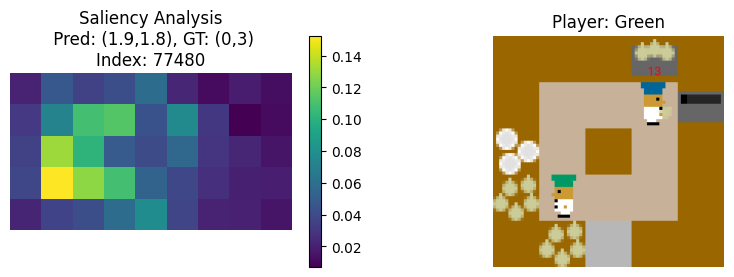

In [19]:
## Saliency map
# Find indices of correctly classified test samples
indices = list(range(0,len(test_player_index)))

# Select a random index from the correctly classified samples
np.random.seed()#For consistent results
rand_index=np.random.randint(0,len(indices))
index = indices[rand_index]

# Retrieve the input image, true label, model output, predicted label for the selected index
pred = test_preds[index]
label = test_labels[index]
output = test_outputs[index]
image_original = test_inputs[index]

img_idx = test_img_index[index]
player_idx = test_player_index[index]

# Add a batch dimension to the input image (via .unsqueeze()) and set requires_grad to True for saliency analysis
image = image_original.unsqueeze(0)
image.requires_grad = True

# Compute the scores and gradients for the input image
# To compute the scores, do a forward pass of the image and then take the argmax
# Use this index to extract the score_max value from "scores"
# Then perform a backward step so that it backpropagates the gradient
scores = model_cnn.forward(image)
score_max_index = torch.argmax(scores)
score_max = scores[0, score_max_index]
score_max.backward() # Do the backward step here for the gradient calculation

# Calculate the saliency map by finding the maximum absolute gradient values across channels
# You can use .abs() and torch.max()
grad = image.grad
grad_abs = torch.squeeze(grad.abs())
grad_max = torch.max(grad_abs,dim=0).values
# print(grad_max)

# Create a subplot to display the original image and saliency map side by side
plt.rcParams["figure.figsize"] = (10, 3)
plt.subplot(1,2,1)
plt.imshow(grad_max)
plt.colorbar()
# plt.bar(range(1,len(grad_abs)+1),grad_abs)
player_actions = ["INTERACT","Right","Left","Down","Up"]
player_colours = ["Blue","Green"]
plt.title(f"Saliency Analysis\n Pred: ({round(pred[1].item(),1)},{round(pred[0].item(),1)}), GT: ({round(label[1].item())},{round(label[0].item())})\nIndex: {img_idx}")
plt.axis('off')
# Show the original image and saliency map side by side
for img_action_no in [0,1,2,3,4,5]:
    try:
        image = torchvision.io.read_image(f"/SRP-Dylan/img_data/{img_action_no}/{img_idx}.png")
        break
    except:
        pass
plt.subplot(1,2,2)
# print(img_idx,player_idx)
plt.title(f"Player: {player_colours[player_idx]}")
image = image.permute(1,2,0)
plt.axis('off')
# image = torchvision.transforms.functional.rotate(image,90)
plt.imshow(image)
plt.show()